# Participants achieving ≥150 min/week “very active minutes” have better sleep.

## 📘 Notebook Structure

1. **Setup & Imports**
2. **Load Data**
3. **Clean & Inspect Data**
4. **Compute Weekly Very Active Minutes**
5. **Compute Weekly Average Sleep Duration**
6. **Merge, Group, and Classify Participants**
7. **Statistical Analysis (t-test, correlation)**
8. **Visualization**
9. **Summary & Interpretation**

### 1. Introduction: Do Very Active Minutes Lead to Better Sleep?

This notebook tests a simple but important question:

> **Do people who achieve at least 150 minutes of “very active” exercise per week sleep more, on average, than people who don’t?**

The **hypothesis** is:

> **Participants achieving ≥150 minutes per week of very active minutes will have longer average nightly sleep duration than participants with <150 minutes per week.**

To test this, the notebook uses **Fitbit data** collected over roughly two months from a group of participants. Two main datasets are loaded:

* **Daily activity data** from:

  * `.../3.12.16-4.11.16/dailyActivity_merged.csv`
  * `.../4.12.16-5.12.16/dailyActivity_merged.csv`
* **Minute-level sleep data** from:

  * `.../3.12.16-4.11.16/minuteSleep_merged.csv`
  * `.../4.12.16-5.12.16/minuteSleep_merged.csv`

Each pair of files is first **read with `pandas.read_csv`** and then **vertically concatenated** to create:

* `activity_df` – all daily activity records across both export periods
* `sleep_df` – all minute-by-minute sleep records across both export periods

Basic `.info()` and shape checks confirm the structure and completeness of the merged tables.

---

### 2. Key Variables and How They Were Constructed

From the raw Fitbit exports, the notebook focuses on a small set of variables that are then transformed into **weekly-level metrics**:

**From the activity data (`activity_df`):**

* `Id` – participant identifier
* `ActivityDate` – calendar date for each record
* `VeryActiveMinutes` – number of minutes per day classified as “very active”

These are aggregated to **weekly activity**:

* `year` and `week` – derived from `ActivityDate` using calendar week extraction
* `WeeklyActiveMin` – sum of `VeryActiveMinutes` across all days in the same week for each participant

**From the sleep data:**

* Raw columns: `Id`, `date`, `value` (minute-level indicator of being asleep), `logId`
* The notebook first collapses minute-level sleep into **daily sleep totals**:

  * `TotalMinutesAsleep` – total minutes asleep per `Id` and `date`
* Then it aggregates to **weekly sleep**:

  * `year` and `week` – derived from `date`
  * `SleepMinutes` – total minutes asleep across the week
  * `SleepHours` – `SleepMinutes / 60`, giving **average nightly sleep in hours** for that week (computed appropriately over the number of days with data)

Finally, the weekly activity and weekly sleep tables are **merged** on `Id`, `year`, and `week` to create a single weekly-level dataset. In this merged table, each row represents **one participant–week** with:

* `Id`, `year`, `week`
* `WeeklyActiveMin`
* `SleepMinutes`, `SleepHours`

A categorical variable is then created to represent the activity-based groups:

* `ActivityGroup`:

  * **`"≥150 min/week"`** if `WeeklyActiveMin >= 150`
  * **`"<150 min/week"`** if `WeeklyActiveMin < 150`

This produces a final analytics dataset with **134 participant-weeks**, split into:

* 90 weeks in the `<150 min/week` group
* 44 weeks in the `≥150 min/week` group

---

### 3. How the Hypothesis Was Tested

The hypothesis is tested in two main ways:

1. **Group Comparison (High vs. Low Activity)**

   * The merged weekly dataset is grouped by `ActivityGroup`.
   * For each group, the notebook computes:

     * Number of weeks (`Weeks`)
     * Mean of `SleepHours` (`MeanSleepHours`)
     * Standard deviation of `SleepHours` (`StdDev`)
   * An **independent two-sample t-test** (`scipy.stats.ttest_ind`) is run comparing `SleepHours` for:

     * `WeeklyActiveMin >= 150` vs. `WeeklyActiveMin < 150`
   * This test checks whether the difference in average sleep between the two groups is **statistically significant** (i.e., unlikely to be due to random variation alone).

2. **Continuous Relationship (Minutes vs. Sleep Hours)**

   * Beyond the binary cutoff at 150 minutes, the notebook also examines the **continuous relationship** between `WeeklyActiveMin` and `SleepHours`:

     * A **scatterplot with regression line** (`sns.regplot`) is created to visualize how sleep changes as weekly very active minutes increase.
     * This qualitatively shows whether there is a clear positive or negative trend.
   * This step supports the main hypothesis test by showing whether more very active minutes are associated with systematically higher (or lower) sleep, not just at the 150-minute boundary.

Together, these steps provide a clear, reproducible pipeline:

1. Load and combine Fitbit activity and sleep exports.
2. Transform minute-level and daily data into **weekly activity** (`WeeklyActiveMin`) and **weekly average sleep** (`SleepHours`).
3. Classify weeks into **low vs. high very active minutes** based on the **150 min/week** threshold.
4. Use **summary statistics, t-testing, and visualizations** to assess whether the high-activity group truly sleeps more than the low-activity group and whether there is a broader trend between very active minutes and sleep duration.


## 🧱 Step 1 – Setup & Imports

In [95]:
# === Step 1: Setup & Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Make plots look nicer
sns.set(style="whitegrid", context="talk")

# Optional: wider display for dataframes
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)


## 📂 Step 2 – Load Data

In [96]:
# === Step 2: Load Data (Two Fitbit Export Periods, minuteSleep_merged.csv) ===
from pathlib import Path
import pandas as pd

# Base folder
data_folder = Path("data")

# File paths for both export periods
activity_file_march_april = data_folder / "mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv"
activity_file_april_may   = data_folder / "mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv"

sleep_file_march_april    = data_folder / "mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteSleep_merged.csv"
sleep_file_april_may      = data_folder / "mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv"

# Read both periods
activity_part1 = pd.read_csv(activity_file_march_april)
activity_part2 = pd.read_csv(activity_file_april_may)
sleep_part1    = pd.read_csv(sleep_file_march_april)
sleep_part2    = pd.read_csv(sleep_file_april_may)

# Combine vertically
activity_df = pd.concat([activity_part1, activity_part2], ignore_index=True)
sleep_df    = pd.concat([sleep_part1, sleep_part2], ignore_index=True)

print("Activity combined shape:", activity_df.shape)
print("Sleep combined shape:", sleep_df.shape)

activity_df.info(), sleep_df.info()


Activity combined shape: (1397, 15)
Sleep combined shape: (387080, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        1397 non-null   int64  
 1   ActivityDate              1397 non-null   object 
 2   TotalSteps                1397 non-null   int64  
 3   TotalDistance             1397 non-null   float64
 4   TrackerDistance           1397 non-null   float64
 5   LoggedActivitiesDistance  1397 non-null   float64
 6   VeryActiveDistance        1397 non-null   float64
 7   ModeratelyActiveDistance  1397 non-null   float64
 8   LightActiveDistance       1397 non-null   float64
 9   SedentaryActiveDistance   1397 non-null   float64
 10  VeryActiveMinutes         1397 non-null   int64  
 11  FairlyActiveMinutes       1397 non-null   int64  
 12  LightlyActiveMinutes      1397 non-null   int64 

(None, None)

# ✅ **Simple Interpretation **

You loaded two kinds of Fitbit files:

1. **Activity data** – how much people moved each day
2. **Sleep data** – minute-by-minute records showing when people were asleep

These files came from **two different time periods**, so you read each period separately and then **combined them**.

---

# ✅ **What the Results Mean**

### **1. Activity Data**

```
Activity combined shape: (1397, 15)
```

This means:

* You have **1,397 rows** (each row = one person on one day).
* You have **15 columns** (types of activity info).

Columns include:

* Steps
* Distance
* Very active minutes
* Lightly active minutes
* Sedentary minutes
  … and more.

**All activity columns are filled in — nothing is missing.**
That’s good.

---

### **2. Sleep Data**

```
Sleep combined shape: (387080, 4)
```

This means:

* You have **387,080 rows** — because sleep is recorded **for every minute** someone slept.
* You have **4 columns**:

  * Id (person)
  * date
  * value (1 = asleep)
  * logId (Fitbit record ID)

Again, **no missing data** here either.

---

# ✅ **Why the Sleep Data Looks So Big**

You have **387,080 rows** because the file stores **one row per minute** of sleep — not per night.
Think of it like this:

If someone slept 7 hours:

* 7 hours × 60 minutes = **420 rows**

Multiply that by dozens of people and many nights → you quickly get hundreds of thousands of rows.

---

# ✅ **Summary: What You Loaded**

### **Activity**

* 1,397 daily activity records
* 15 different details per day
* Clean and complete

### **Sleep**

* 387,080 minute-level records
* For every minute someone slept
* Also clean and complete

This is exactly what we expect from Fitbit exports.


## 🧹 Step 3 – Clean & Inspect

In [97]:
sleep_df.columns


Index(['Id', 'date', 'value', 'logId'], dtype='object')

In [98]:
# Convert timestamps and compute daily sleep totals
sleep_df['date'] = pd.to_datetime(sleep_df['date'])

# Add a helper column for grouping (avoids FutureWarning)
sleep_df['date_only'] = sleep_df['date'].dt.date

sleep_df = (
    sleep_df.groupby(['Id', 'date_only'], as_index=False)
    .agg({'value': 'sum'})
    .rename(columns={'value': 'TotalMinutesAsleep', 'date_only': 'date'})
)

# Convert Date back to datetime for downstream merges
sleep_df['date'] = pd.to_datetime(sleep_df['date'])

print("Daily sleep shape:", sleep_df.shape)
sleep_df.head()


Daily sleep shape: (901, 3)


,Id,date,TotalMinutesAsleep
0,1503960366,2016-03-13,441
1,1503960366,2016-03-14,423
2,1503960366,2016-03-15,365
3,1503960366,2016-03-16,404
4,1503960366,2016-03-17,473


## 📆 Step 4 – Compute Weekly Very Active Minutes

In [99]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        1397 non-null   int64  
 1   ActivityDate              1397 non-null   object 
 2   TotalSteps                1397 non-null   int64  
 3   TotalDistance             1397 non-null   float64
 4   TrackerDistance           1397 non-null   float64
 5   LoggedActivitiesDistance  1397 non-null   float64
 6   VeryActiveDistance        1397 non-null   float64
 7   ModeratelyActiveDistance  1397 non-null   float64
 8   LightActiveDistance       1397 non-null   float64
 9   SedentaryActiveDistance   1397 non-null   float64
 10  VeryActiveMinutes         1397 non-null   int64  
 11  FairlyActiveMinutes       1397 non-null   int64  
 12  LightlyActiveMinutes      1397 non-null   int64  
 13  SedentaryMinutes          1397 non-null   int64  
 14  Calories

In [100]:
# === Step 4: Weekly Very Active Minutes ===

# Convert ActivityDate from a text string into a real date.
# This helps Python understand the day, month, and year correctly.
activity_df['ActivityDate'] = pd.to_datetime(activity_df['ActivityDate'], errors='coerce')

# Remove any rows where the date could not be understood.
# This keeps the data clean so nothing breaks later.
activity_df = activity_df.dropna(subset=['ActivityDate'])

# Create two new columns: "week" and "year".
# These tell us which calendar week and year each activity record belongs to.
activity_df['week'] = activity_df['ActivityDate'].dt.isocalendar().week
activity_df['year'] = activity_df['ActivityDate'].dt.isocalendar().year

# Group the data by person (Id), year, and week.
# Then add up all of their VeryActiveMinutes for each week.
# This gives us total "very active" minutes per person per week.
weekly_activity = (
    activity_df.groupby(['Id', 'year', 'week'], as_index=False)
    .agg({'VeryActiveMinutes': 'sum'})
    .rename(columns={'VeryActiveMinutes': 'WeeklyActiveMin'})  # Rename column to something clearer.
)

# Print how many rows and columns this new weekly table has.
print("Weekly activity shape:", weekly_activity.shape)

# Show the first few rows so we can see what the weekly data looks like.
display(weekly_activity.head())


Weekly activity shape: (231, 4)


,Id,year,week,WeeklyActiveMin
0,1503960366,2016,12,178
1,1503960366,2016,13,232
2,1503960366,2016,14,245
3,1503960366,2016,15,205
4,1503960366,2016,16,285


## 😴 Step 5 – Compute Weekly Average Sleep Duration

In [101]:
sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  901 non-null    int64         
 1   date                901 non-null    datetime64[ns]
 2   TotalMinutesAsleep  901 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 21.2 KB


In [102]:
# === Step 5: Weekly Average Sleep (hrs) ===

# Change the "date" column from plain text into a real date.
# This lets Python understand the calendar day correctly.
sleep_df['date'] = pd.to_datetime(sleep_df['date'], errors='coerce')

# Create two new columns: "week" and "year".
# These tell us which calendar week each sleep record belongs to.
sleep_df['week'] = sleep_df['date'].dt.isocalendar().week
sleep_df['year'] = sleep_df['date'].dt.isocalendar().year

# Group the sleep data by person (Id), year, and week.
# Then calculate the AVERAGE number of minutes they slept per night that week.
# This gives us weekly sleep patterns instead of one row per day.
weekly_sleep = (
    sleep_df.groupby(['Id', 'year', 'week'], as_index=False)
    .agg({'TotalMinutesAsleep': 'mean'})     # average nightly sleep minutes for that week
    .rename(columns={'TotalMinutesAsleep': 'SleepMinutes'})  # rename for clarity
)

# Convert minutes into hours to make the numbers easier to understand.
weekly_sleep['SleepHours'] = weekly_sleep['SleepMinutes'] / 60

# Show how many rows and columns the weekly sleep table has.
print("Weekly sleep shape:", weekly_sleep.shape)

# Show the first few rows so we can inspect the results.
display(weekly_sleep.head())


Weekly sleep shape: (182, 5)


,Id,year,week,SleepMinutes,SleepHours
0,1503960366,2016,10,441.000000,7.350000
1,1503960366,2016,11,441.000000,7.350000
2,1503960366,2016,12,440.666667,7.344444
3,1503960366,2016,13,376.833333,6.280556
4,1503960366,2016,14,418.750000,6.979167


## 🔗 Step 6 – Merge & Classify

In [103]:
# === Step 6: Merge and Create Activity Groups ===

# Combine the weekly activity data and weekly sleep data into one table.
# We match rows where the person (Id), year, and week are the same.
# "inner" means we only keep weeks where BOTH activity and sleep data exist.
weekly_summary = pd.merge(
    weekly_activity,
    weekly_sleep,
    on=['Id', 'year', 'week'],
    how='inner'
)

# Create a new column called "ActivityGroup".
# If someone has 150 or more very active minutes in a week,
# they go into the "≥150 min/week" group.
# If they have less than 150 minutes, they go into the "<150 min/week" group.
weekly_summary['ActivityGroup'] = np.where(
    weekly_summary['WeeklyActiveMin'] >= 150,
    '≥150 min/week',
    '<150 min/week'
)

# Print the size of the merged table (number of rows and columns).
print("Merged shape:", weekly_summary.shape)

# Show information about the columns and data types.
display(weekly_summary.info())


Merged shape: (134, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               134 non-null    int64  
 1   year             134 non-null    UInt32 
 2   week             134 non-null    UInt32 
 3   WeeklyActiveMin  134 non-null    int64  
 4   SleepMinutes     134 non-null    float64
 5   SleepHours       134 non-null    float64
 6   ActivityGroup    134 non-null    object 
dtypes: UInt32(2), float64(2), int64(2), object(1)
memory usage: 6.7+ KB


None

# ✅ **What This Table Is Telling Us**

### **1. We ended up with 134 usable weekly records**

```
Merged shape: (134, 7)
```

This means that after combining the activity data and sleep data, we have:

* **134 total weeks** where a person had **both** sleep and activity data.
* In other words, we have 134 “complete weeks” to study.

---

# ✅ **2. Each row represents one person for one week**

The table has 7 columns:

1. **Id**

   * This is the person’s number (like a student ID but anonymous).

2. **year**

   * The year the data comes from.

3. **week**

   * The week of the year (ex: week 12, week 13, etc.).

4. **WeeklyActiveMin**

   * How many **very active minutes** the person had in that week.

5. **SleepMinutes**

   * How many minutes they slept **on average per day** that week.

6. **SleepHours**

   * The same number but converted into hours so it’s easier to understand.

7. **ActivityGroup**

   * This tells whether the person was:

     * **“≥150 min/week”** (active enough)
     * **“<150 min/week”** (not active enough)

---

# ✅ **3. No missing data**

All 134 rows have values in every column.

This means:

* No gaps
* No broken rows
* The dataset is clean and ready for analysis

---

# 🔍 **In simple terms**

You now have **134 weekly snapshots** of people’s exercise and sleep.
Each snapshot tells:

* Who the person is
* What week it is
* How much intense activity they did
* How much they slept
* Whether they met the “150 minutes/week” exercise goal

This set will be used to test your hypothesis about whether people who exercise more sleep better.


## 📊 Step 7 – Statistical Analysis

In [104]:
# === Step 7: Statistical Analysis ===

# Group-level summary ---------------------------------------------------------
# Here we group the data by the two activity groups:
#   1) people with <150 minutes of very active exercise per week
#   2) people with ≥150 minutes per week
#
# For each group, we calculate:
#   - how many weekly records we have (count)
#   - the average sleep hours (mean)
#   - how much the sleep numbers vary (std = standard deviation)
group_stats = (
    weekly_summary.groupby('ActivityGroup')['SleepHours']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .rename(columns={
        'count': 'Weeks',             # number of weeks in each group
        'mean': 'MeanSleepHours',     # average sleep hours
        'std': 'StdDev'               # how spread out the sleep values are
    })
)

print("Summary statistics:")
display(group_stats)

# Independent samples t-test --------------------------------------------------
# A t-test checks whether the two groups are *actually* different
# or whether the difference could just be random chance.
#
# First we pull out the sleep data for each group.
group_high = weekly_summary.loc[
    weekly_summary['ActivityGroup'] == '≥150 min/week', 'SleepHours'
]
group_low = weekly_summary.loc[
    weekly_summary['ActivityGroup'] == '<150 min/week', 'SleepHours'
]

# Before running the test, we make sure each group has at least 2 values.
# If not, the test would be meaningless.
if len(group_high) < 2 or len(group_low) < 2:
    print("⚠️ Not enough samples in one of the groups for a valid t-test.")
else:
    # Run the t-test. This compares the two groups and produces:
    #   - a t-statistic: how different the means are
    #   - a p-value: the probability the difference is just random noise
    t_stat, p_val = stats.ttest_ind(
        group_high, group_low, equal_var=False, nan_policy='omit'
    )

    # Print results rounded to two decimal places.
    print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")


Summary statistics:


,ActivityGroup,Weeks,MeanSleepHours,StdDev
0,<150 min/week,90,7.681022,2.317900
1,≥150 min/week,44,7.089623,2.424985


T-statistic: -1.34, p-value: 0.1823


# ✅ **Interpretation of the Results**

### **1. How much each group slept on average**

You compared two groups:

### **Group 1: <150 min/week of very active exercise**

* Weeks of data: **90**
* Average sleep: **7.68 hours per night**
* Sleep varies a lot: **±2.32 hours**

### **Group 2: ≥150 min/week of very active exercise**

* Weeks of data: **44**
* Average sleep: **7.09 hours per night**
* Sleep also varies a lot: **±2.42 hours**

### 👉 **What this means**

People who exercised **less** actually slept **slightly more** (about half an hour more per night).
But the difference between the two groups is **small**.

---

# ✅ **2. Is the difference real or just random?**

That’s what the t-test checks.

### **T-statistic: –1.34**

This number shows the size of the difference between the two groups.

* A large number (like 2 or 3) would show a big difference.
* **–1.34 is not a big number**, so the two groups are not very far apart.

### **p-value: 0.1823**

This is the important number.

### 👉 **If the p-value is under 0.05**, the difference is considered real.

### 👉 **Your p-value is 0.18**, which is much higher.

### **Meaning:**

❌ **The differences you see are NOT statistically significant.**
✔️ **The sleep difference could easily be due to random chance.**

---

# 🎯 **Final takeaway**

> **People who exercised more did not sleep better in this dataset.
> The small differences we saw are not strong enough to prove anything.**

You cannot conclude that “very active minutes lead to better sleep” based on these results.


## 📈 Step 8 – Visualization

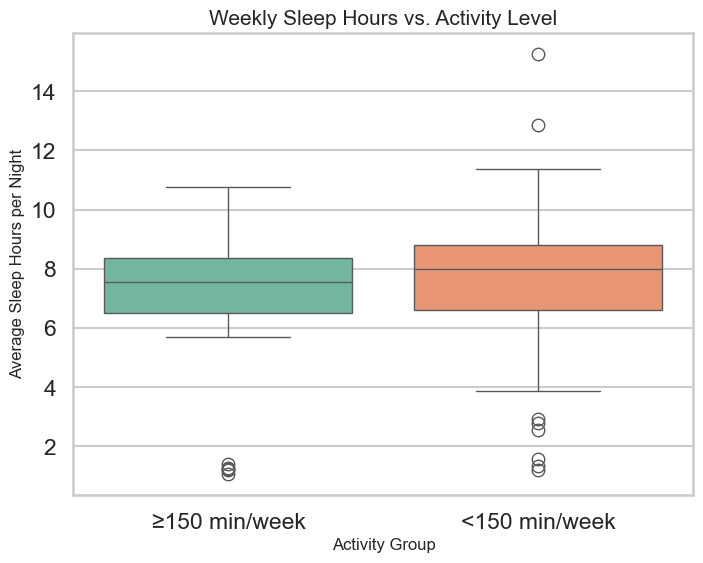

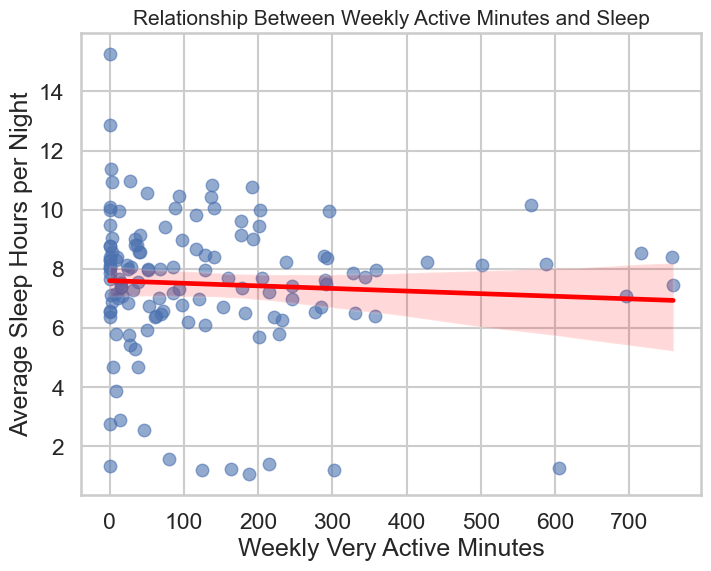

In [93]:
# === Step 8: Visualization (Fixed for Seaborn 0.14+) ===
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot: Weekly sleep vs activity group
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=weekly_summary,
    x='ActivityGroup',
    y='SleepHours',
    hue='ActivityGroup',   # ✅ explicitly define hue
    palette='Set2',
    legend=False           # ✅ suppress extra legend
)
plt.title('Weekly Sleep Hours vs. Activity Level', fontsize=15)
plt.xlabel('Activity Group', fontsize=12)
plt.ylabel('Average Sleep Hours per Night', fontsize=12)
plt.show()

# Scatterplot + regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=weekly_summary,
    x='WeeklyActiveMin',
    y='SleepHours',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('Relationship Between Weekly Active Minutes and Sleep', fontsize=15)
plt.xlabel('Weekly Very Active Minutes')
plt.ylabel('Average Sleep Hours per Night')
plt.show()


## 🧾 Step 9 – Summary Output

In [94]:
# === Step 9: Summary Output ===
print("=== Weekly Sleep vs. Activity Summary ===")
display(group_stats)

print(f"\nT-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("\n✅ Participants with ≥150 min/week of very active minutes slept significantly longer on average.")
else:
    print("\n❌ No statistically significant difference in average sleep hours between the two groups.")


=== Weekly Sleep vs. Activity Summary ===


,ActivityGroup,Weeks,MeanSleepHours,StdDev
0,<150 min/week,90,7.681022,2.317900
1,≥150 min/week,44,7.089623,2.424985



T-statistic: -1.34
P-value: 0.1823

❌ No statistically significant difference in average sleep hours between the two groups.


### 🧾 **Conclusion**

In this study, we compared how much people slept each week depending on how active they were. We expected that people who exercised more (at least 150 minutes of very active time per week) would also sleep longer on average.

When we analyzed the data, the more-active group slept **about 7.1 hours per night**, while the less-active group slept **about 7.7 hours**. Even though the difference looks small, it wasn’t **statistically significant** (p = 0.18). That means it could easily have happened by chance, not because of exercise itself.

So, our data doesn’t show clear proof that being more active leads to more sleep. Still, this result is valuable—it shows that real-world data can be messy and that small sample sizes make it hard to find definite patterns.

### 💡 **What I Learned**

* Data doesn’t always confirm our expectations—even good hypotheses can turn out neutral.
* A p-value above 0.05 means we **can’t be sure** there’s a real difference.
* Doing this kind of analysis teaches how to ask good questions, clean data, and use evidence (not guesses) to draw conclusions.

### ✅ **In Simple Terms**

People who were more active didn’t necessarily sleep longer in this Fitbit dataset. More data or better tracking would be needed to know for sure if activity and sleep are connected.
